# UDS emulator 

## Preliminaries

In [1]:
from my_imports import *

In [2]:
yaml_path = 'config_file.yaml'
yaml_data = utils.load_yaml(yaml_path)

# Directories
training_simulations_path   = yaml_data['training_simulations_path']
validation_simulations_path = yaml_data['validation_simulations_path']

inp_path =  yaml_data['inp_path']

## Create simulation objects from data

In [3]:
list_of_training_simulations    = os.listdir(training_simulations_path)
list_of_validation_simulations  = os.listdir(validation_simulations_path)

print('Number of training simulations: ', len(list_of_training_simulations))
print('Number of validation simulations: ', len(list_of_validation_simulations))


Number of training simulations:  163
Number of validation simulations:  29


In [4]:
num_events = 10

validation_simulations = utils.extract_simulations_from_folders(validation_simulations_path, inp_path, max_events =num_events)

validation_windows = []
events_to_validate= list(range(num_events))
for event in events_to_validate:
    sim = validation_simulations[event]
    validation_windows += sim.get_all_windows(steps_ahead = 10)

The file does not have [STORAGE]

The file does not have '[PUMPS]\n'
The file does not have '[ORIFICES]\n'
The file does not have '[WEIRS]\n'


In [5]:
num_events = 10
training_simulations = utils.extract_simulations_from_folders(training_simulations_path, inp_path, max_events = num_events)

training_windows = []
events_to_train= list(range(num_events))
for event in events_to_train:
    sim = training_simulations[event]
    training_windows += sim.get_all_windows(steps_ahead = 10)

The file does not have [STORAGE]

The file does not have '[PUMPS]\n'
The file does not have '[ORIFICES]\n'
The file does not have '[WEIRS]\n'


## Normalizer

In [6]:
normalizer = Normalizer(training_windows)

In [7]:
normalized_training_windows = normalizer.get_list_normalized_training_windows()
training_loader = DataLoader(normalized_training_windows, batch_size=32, shuffle = True)

In [8]:
normalized_validation_windows = [normalizer.normalize_window(val_win) for val_win in validation_windows]
validation_loader = DataLoader(normalized_validation_windows, batch_size=32)

## Training GNN

In [9]:
gnn_model = GNNModel()
optimizer = optim.Adam(gnn_model.parameters(), lr = 0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
loss_fn = nn.MSELoss()

In [10]:
history = train(
    model = gnn_model,
    optimizer = optimizer,
    scheduler = scheduler,
    loss_fn = loss_fn,
    train_dl = training_loader,
    val_dl = validation_loader,
    epochs = 50,
    device = 'cpu',
    report_freq = 10
    )


train() called:model=GNNModel, opt=Adam(lr=0.010000), epochs=50,device=cpu

Epoch   1/ 50, train loss:  0.68, val loss:  1.26
Epoch  10/ 50, train loss:  0.57, val loss:  1.53
Epoch  20/ 50, train loss:  0.54, val loss:  1.70
Epoch  30/ 50, train loss:  0.52, val loss:  1.72
Epoch  40/ 50, train loss:  0.51, val loss:  1.76
Epoch  50/ 50, train loss:  0.51, val loss:  1.80

Time total:     389.88 sec
Time per epoch:  7.80 sec


## Results

In [13]:
viz.plot_loss(history)

## Using the metamodel

In [14]:
def tensor_heads_to_normalized_pd(tensor_heads, normalizer, name_nodes):
    normalized_heads_tensor = normalizer.unnormalize_heads(tensor_heads)
    normalized_heads_np = normalized_heads_tensor.detach().numpy()
    normalized_heads_pd = pd.DataFrame(dict(zip(name_nodes, normalized_heads_np)))
    return normalized_heads_pd

In [15]:
val_event =  validation_simulations[0]

length = val_event.simulation_length
sim_in_window = val_event.get_all_windows(length-2)[0]
norm_sim_in_window = normalizer.normalize_window(sim_in_window)

name_nodes = norm_sim_in_window.name_nodes

swmm_heads_pd       = tensor_heads_to_normalized_pd(sim_in_window['y'],             normalizer, name_nodes)
predicted_heads_pd  = tensor_heads_to_normalized_pd(gnn_model(norm_sim_in_window),  normalizer, name_nodes)

<AxesSubplot:>

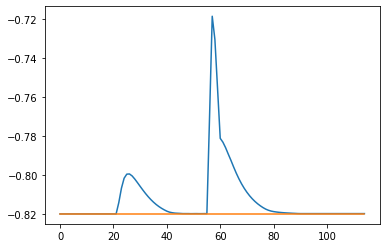

In [16]:
node = name_nodes[24]

swmm_heads_pd[node].plot()
predicted_heads_pd[node].plot()

# Scratchpad

In [35]:

columns = ['Node', 'x_coord' , 'y_coord']
node_names = norm_sim_in_window.name_nodes
coordinates = norm_sim_in_window.pos.numpy()

x_coord = coordinates[:,0]
y_coord = coordinates[:,1]

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_coord, y=y_coord,
                    mode='markers',
                    name='coordinates',
                    text = node_names
                    )
    )

fig.update_layout(width=500, height=800)

fig.show()


In [31]:
x_coord

array([138143.83, 137673.34, 137834.05, 137884.95, 137716.28, 137710.52,
       137706.11, 137757.8 , 137751.2 , 137747.17, 137794.31, 137811.2 ,
       137791.92, 137756.61, 137772.28, 137732.56, 137750.6 , 137712.55,
       137729.27, 137797.9 , 137758.38, 137770.53, 137815.94, 137826.5 ,
       137849.23, 137837.9 , 137838.23, 137798.25, 137850.4 , 137808.78,
       137831.03, 137810.52, 137837.6 , 137849.58, 137867.34, 137908.1 ,
       137918.52, 137949.34, 137870.52, 137899.67, 137890.27, 137907.8 ,
       137888.17, 137922.38, 137926.02, 137945.2 , 137925.28, 137957.94,
       137984.86, 137982.03, 137611.56, 137608.06, 137595.84, 137692.64,
       137707.92, 137688.42, 137646.39, 137660.11, 137695.31, 137682.33,
       137647.95, 137691.25, 137712.45, 137738.28, 137764.48, 137754.27,
       137758.34, 137717.97, 137729.33, 137775.27, 137773.34, 137783.64,
       137796.4 , 137806.67, 137870.45, 137851.17, 137831.83, 137811.03,
       137790.58, 137808.16, 137809.75, 137856.48, 